In [2]:
from abc import ABC, abstractmethod
from typing import Union
from types import FunctionType
import copy

import tensorflow as tf
import matplotlib.pyplot as plt
import math


In [3]:
class ActivationFunction(ABC):
    tensor = tf.Variable(initial_value=[], dtype=tf.float32)
    results = tf.Variable(initial_value=[], dtype=tf.float32)

    def __init__(self, tensor: tf.Variable) -> None:
        self.tensor = tensor

    @abstractmethod
    def activation_function(self, x) -> tf.Variable:
        pass

    def show_results(self) -> None:
        print(f'Results: \n{self.results}')
        self.plot_result()

    def plot_result(self) -> None:
        if len(self.tensor.shape) < 3:
            plt.plot(self.tensor, self.results, marker='o', markersize=3)
            plt.grid()
            plt.show()
        else:
            print('INFO: The tensor must not have more than 2 dimensions to be plotted!')

    def execute_activation_function(self) -> None:
        self.results = tf.map_fn(
            fn=self.activation_function,
            elems=self.results
        )

    def run(self) -> None:
        self.results = copy.deepcopy(self.tensor)

        try:
            self.execute_activation_function()
        except Exception as e:
            print(f'Exception: {e}')
        else:
            self.show_results()


# Deserialize

Returns activation function given a string identifier.


In [4]:
def deserialize(function_name: str) -> Union[FunctionType, None]:
    try:
        if type(function_name) == str:
            func: FunctionType = eval(function_name)
            func
        else:
            raise ValueError('Parameter must be a string!')
    except ValueError as exception:
        print(exception)
    except NameError:
        print('Unknown activation function')
    else:
        return func


In [5]:
deserialize('linear')


Unknown activation function


In [6]:
deserialize('bhaskara')


Unknown activation function


In [7]:
def hello_world() -> None:
    print("Hello World!")


deserialize(hello_world)


Parameter must be a string!


## Elu (Exponential Linear Unit)

The exponential linear unit (ELU) with `alpha > 0` is: `x` if `x > 0` and
`alpha * (exp(x) - 1)` if `x < 0` The ELU hyperparameter `alpha` controls the
value to which an ELU saturates for negative net inputs. ELUs diminish the
vanishing gradient effect.

ELUs have negative values which pushes the mean of the activations closer to
zero. Mean activations that are closer to zero enable faster learning as they
bring the gradient closer to the natural gradient. ELUs saturate to a negative
value when the argument gets smaller. Saturation means a small derivative which
decreases the variation and the information that is propagated to the next layer.

$$
\begin{cases}
\alpha (e^x - 1) &  x \leq 0 \\
x     &    x>0    \\
\end{cases}
$$


Results: 
[-14.999319  -14.998877  -14.998149  -14.996947  -14.994968  -14.991704
 -14.986321  -14.9774475 -14.962818  -14.938698  -14.898931  -14.833365
 -14.7252655 -14.547039  -14.253195  -13.768724  -12.969971  -11.653048
  -9.481809   -5.90204     0.          0.5         1.          1.5
   2.          2.5         3.          3.5         4.          4.5
   5.          5.5         6.          6.5         7.          7.5
   8.          8.5         9.          9.5      ]


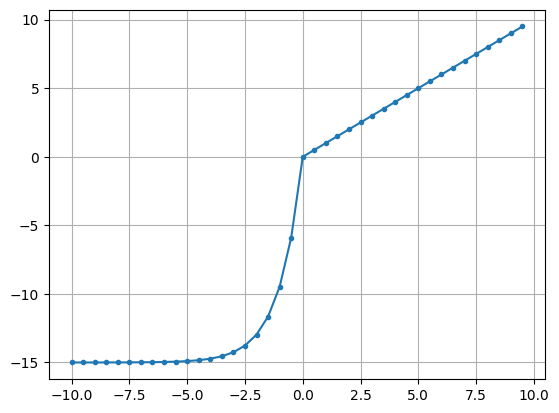

In [8]:
class Elu(ActivationFunction):
    ALPHA: float = 1.0

    def __init__(self,
                 tensor: tf.Variable,
                 alpha: float = 1.0) -> None:
        super().__init__(tensor)
        self.ALPHA = alpha

    def activation_function(self, x) -> tf.Tensor:
        if self.ALPHA > 0:
            if tf.rank(x) == 0:
                if x > 0:
                    return x
                else:
                    return self.ALPHA * (tf.exp(x) - 1)
            else:
                for element in x:
                    self.activation_function(element)
                return x
        else:
            raise Exception('Alpha must be bigger than zero!')


Elu(
    tensor=tf.range(start=-10.0, limit=10.0, delta=0.5, dtype=tf.float32),
    alpha=15.0
).run()


# Exponential


Results: 
[4.5399931e-05 1.2340980e-04 3.3546262e-04 9.1188197e-04 2.4787523e-03
 6.7379470e-03 1.8315639e-02 4.9787067e-02 1.3533528e-01 3.6787945e-01
 1.0000000e+00 2.7182817e+00 7.3890562e+00 2.0085537e+01 5.4598148e+01
 1.4841316e+02 4.0342880e+02 1.0966332e+03 2.9809580e+03 8.1030840e+03
 2.2026465e+04 5.9874141e+04 1.6275480e+05 4.4241341e+05 1.2026042e+06
 3.2690172e+06 8.8861110e+06 2.4154952e+07 6.5659968e+07 1.7848230e+08]


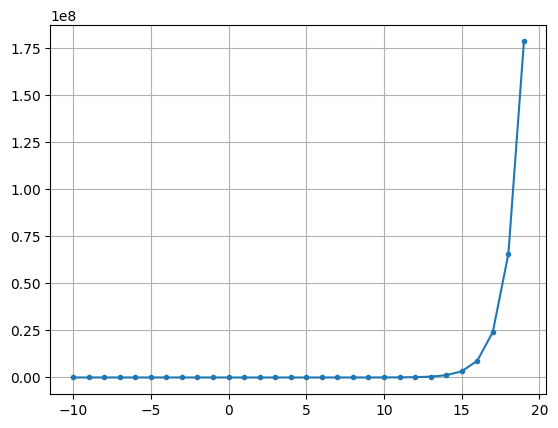

In [9]:
class Exponential(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        return tf.exp(x)


Exponential(tensor=tf.range(start=-10.0, limit=20.0, dtype=tf.float32)).run()


# GELU (Gaussian Error Linear Unit)

Gaussian error linear unit (GELU) computes `x * P(X <= x)`, where `P(X) ~ N(0, 1)`.
The (GELU) nonlinearity weights inputs by their value, rather than gates inputs
by their sign as in ReLU.

$$
\frac{1}{2}x (1 + erf(\frac{x}{\sqrt{2}})) = x^\phi(x)
$$


Results: 
[-0.00000000e+00 -0.00000000e+00 -1.63912773e-06 -1.55568123e-05
 -1.26361847e-04 -8.14229250e-04 -4.04950976e-03 -1.55241787e-02
 -4.55002785e-02 -1.00210726e-01 -1.58655286e-01 -1.54268771e-01
  0.00000000e+00  3.45731229e-01  8.41344714e-01  1.39978933e+00
  1.95449972e+00  2.48447585e+00  2.99595070e+00  3.49918580e+00
  3.99987364e+00  4.49998426e+00  4.99999809e+00  5.50000000e+00]


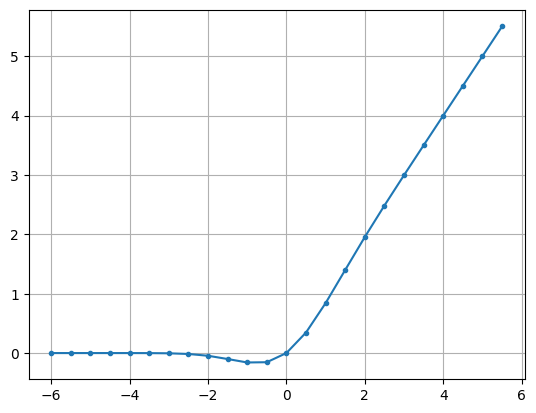

In [10]:
class Gelu(ActivationFunction):
    APPROXIMATE: bool = False

    def __init__(self,
                 tensor: tf.Variable,
                 approximate: bool = False) -> None:
        super().__init__(tensor)
        self.APPROXIMATE = approximate

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        if self.APPROXIMATE:
            return self.calculate_approximate(x)
        else:
            return self.calculate_not_approximate(x)

    def calculate_approximate(self, x: tf.Variable) -> tf.Variable:
        y = tf.sqrt(2 / math.pi) * (x + 0.044715 * tf.math.pow(x, 3))

        return tf.math.multiply(x, 0.5) * tf.reduce_sum([tf.tanh(y), 1])

    def calculate_not_approximate(self, x: tf.Variable) -> tf.Variable:
        return tf.math.multiply(x, 0.5) * \
            tf.reduce_sum([tf.math.erf(x / tf.sqrt(2.0)), 1.0])


Gelu(tensor=tf.range(start=-6.0, limit=6.0, delta=0.5, dtype=tf.float32)).run()


# Get


In [11]:
def serialize(function_name: Union[FunctionType, str]) -> FunctionType:
    try:
        if type(function_name) == str:
            func: FunctionType = eval(function_name)
        elif type(function_name) == FunctionType:
            func: FunctionType = function_name

        func
    except NameError:
        raise ValueError(
            'ValueError: Input is an unknown function or string, '
            'i.e., the input does not denote any defined function.')
    else:
        return func


In [12]:
try:
    serialize(linear)
except Exception as e:
    print(e)


name 'linear' is not defined


In [13]:
try:
    serialize('relu')
except Exception as e:
    print(e)


ValueError: Input is an unknown function or string, i.e., the input does not denote any defined function.


In [14]:
try:
    serialize('bhaskara')
except ValueError as e:
    print(e)


ValueError: Input is an unknown function or string, i.e., the input does not denote any defined function.


# Hard Sigmoid


Results: 
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.09999999 0.19999999
 0.3        0.4        0.5        0.6        0.7        0.8
 0.9        1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


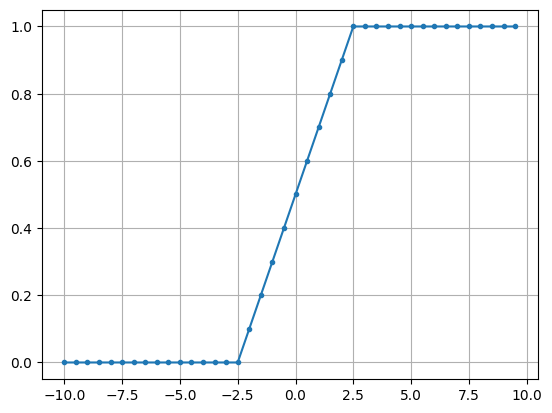

In [15]:
class HardSigmoid(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        if tf.less(x, -2.5):
            return tf.Variable(0.0)
        elif tf.greater(x, 2.5):
            return tf.Variable(1.0)
        else:
            return tf.multiply(0.2, x) + 0.5


HardSigmoid(
    tensor=tf.range(start=-10.0, limit=10.0, delta=0.5, dtype=tf.float32)
).run()


# Linear (or Identity)


Results: 
[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.]


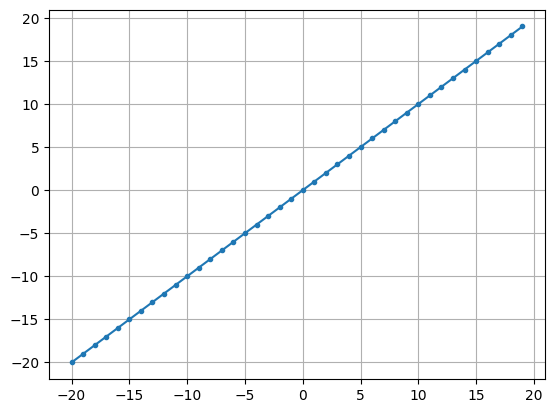

In [16]:
class Linear(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        return x


Linear(tensor=tf.range(start=-20.0, limit=20.0, dtype=tf.float32)).run()


# Relu

With default values, this returns the standard ReLU activation: `max(x, 0)`, the
element-wise maximum of 0 and the input tensor.

Modifying default parameters allows you to use non-zero thresholds, change the
max value of the activation, and to use a non-zero multiple of the input for
values below the threshold.

$$
\begin{cases}
0.01x &  x<0 \\
x &  x \geq 0 \\
\end{cases}
$$


Results: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.
 16. 17. 18. 19.]


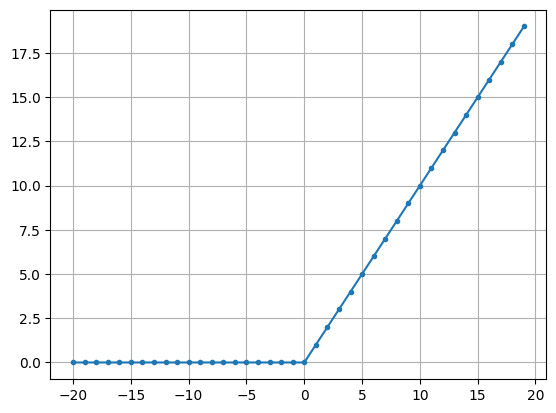

In [17]:
class Relu(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        return max(0, x)


Relu(tensor=tf.range(start=-20.0, limit=20.0, dtype=tf.float32)).run()


# Selu

The Scaled Exponential Linear Unit (SELU) activation function is defined as:

- `if x > 0: return scale * x`
- `if x < 0: return scale * alpha * (exp(x) - 1)`

where `alpha` and `scale` are pre-defined constants (`alpha=1.67326324` and
`scale=1.05070098`).

Basically, the SELU activation function multiplies `scale` (> 1) with the output
of the `tf.keras.activations.elu` function to ensure a slope larger than one for
positive inputs.

The values of `alpha` and `scale` are chosen so that the mean and variance of
the inputs are preserved between two consecutive layers as long as the weights
are initialized correctly (see `tf.keras.initializers.LecunNormal` initializer)
and the number of input units is "large enough" (see reference paper for more
information).

$$
\begin{cases}
\alpha (e^x - 1) &  x<0 \\
x     &    x \geq 0    \\
\end{cases}
$$


Results: 
[-1.7580194  -1.7579677  -1.7578824  -1.7577416  -1.7575096  -1.7571269
 -1.7564961  -1.7554561  -1.7537414  -1.7509143  -1.7462534  -1.7385685
 -1.7258986  -1.7050093  -1.6705687  -1.6137857  -1.5201665  -1.3658143
 -1.1113307  -0.69175816  0.          0.5253505   1.050701    1.5760515
  2.101402    2.6267526   3.152103    3.6774535   4.202804    4.7281547 ]


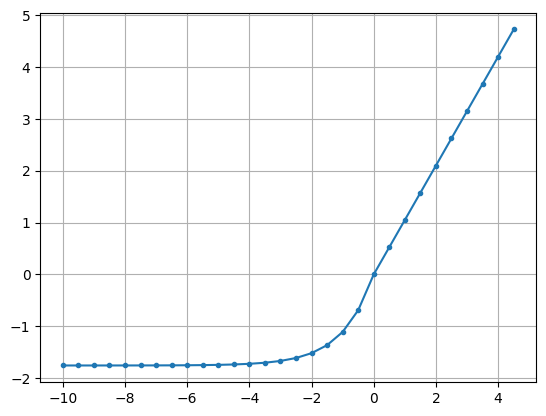

In [18]:
class Selu(ActivationFunction):
    ALPHA: float = 1.67326324
    SCALE: float = 1.05070098

    def __init__(self,
                 tensor: tf.Variable,
                 alpha: float = 1.67326324,
                 scale: float = 1.05070098) -> None:
        super().__init__(tensor)
        self.ALPHA = alpha
        self.SCALE = scale

    def activation_function(self, x) -> tf.Variable:
        if x > 0:
            return self.SCALE * x
        elif x < 0:
            return self.SCALE * self.ALPHA * (tf.exp(x) - 1)
        else:
            return x


Selu(tensor=tf.range(start=-10.0, limit=5.0, delta=0.5, dtype=tf.float32)).run()


# Serialize

Returns the string identifier of an activation function.


In [19]:
def serialize(activation: FunctionType) -> str:
    if type(activation) == FunctionType:
        return activation.__name__
    else:
        raise ValueError('ValueError: The input function is not a valid one.')


In [20]:
try:
    print(serialize(hello_world))
except ValueError as e:
    print(e)


hello_world


# Sigmoid (or Logistic Activation Function)

Applies the sigmoid activation function. For small values (<-5), `sigmoid`
returns a value close to zero, and for large values (>5) the result of the
function gets close to 1.

Sigmoid is equivalent to a 2-element Softmax, where the second element is assumed
to be zero. The sigmoid function always returns a value between 0 and 1.

$$
\frac{x}{1 + e^{-x}}
$$


Results: 
[2.06115369e-09 5.60279645e-09 1.52299808e-08 4.13993781e-08
 1.12535155e-07 3.05902233e-07 8.31528041e-07 2.26032421e-06
 6.14417422e-06 1.67014223e-05 4.53978719e-05 1.23394580e-04
 3.35350138e-04 9.11051175e-04 2.47262302e-03 6.69285096e-03
 1.79862101e-02 4.74258736e-02 1.19202919e-01 2.68941432e-01
 5.00000000e-01 7.31058598e-01 8.80797029e-01 9.52574134e-01
 9.82013762e-01 9.93307173e-01 9.97527421e-01 9.99089003e-01
 9.99664664e-01 9.99876618e-01 9.99954581e-01 9.99983311e-01
 9.99993801e-01 9.99997735e-01 9.99999166e-01 9.99999642e-01
 9.99999881e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00]


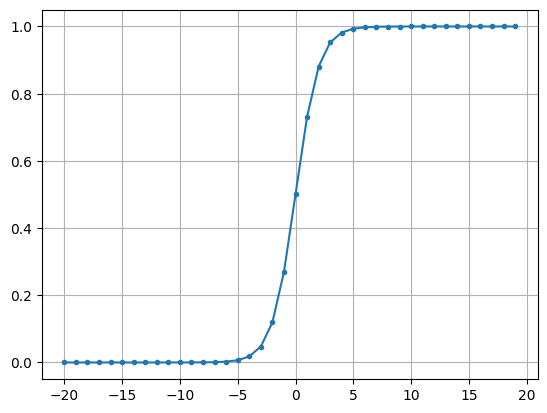

In [21]:
class Sigmoid(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        return 1 / (1 + tf.exp(tf.math.negative(x)))


Sigmoid(tensor=tf.range(start=-20.0, limit=20.0, dtype=tf.float32)).run()


# Softmax

Converts a vector of values to a probability distribution.

The elements of the output vector are in range (0, 1) and sum to 1.

Each vector is handled independently. The `axis` argument sets which axis of the
input the function is applied along.

Softmax is often used as the activation for the last layer of a classification
network because the result could be interpreted as a probability distribution.

$$
\frac{e^{x_i}}{\displaystyle\sum^J_{j=1} {e^{x_j}}}
$$


Results: 
[1.33711420e-09 2.20452856e-09 3.63465325e-09 5.99253003e-09
 9.88001236e-09 1.62893858e-08 2.68566556e-08 4.42791404e-08
 7.30039602e-08 1.20363183e-07 1.98445335e-07 3.27181056e-07
 5.39430346e-07 8.89370313e-07 1.46632374e-06 2.41755924e-06
 3.98588099e-06 6.57160717e-06 1.08347485e-05 1.78634800e-05
 2.94518995e-05 4.85579731e-05 8.00585622e-05 1.31994253e-04
 2.17621739e-04 3.58797581e-04 5.91557240e-04 9.75312898e-04
 1.60801911e-03 2.65117548e-03 4.37104935e-03 7.20664160e-03
 1.18817445e-02 1.95896830e-02 3.22979279e-02 5.32502830e-02
 8.77948701e-02 1.44749284e-01 2.38651216e-01 3.93469334e-01]


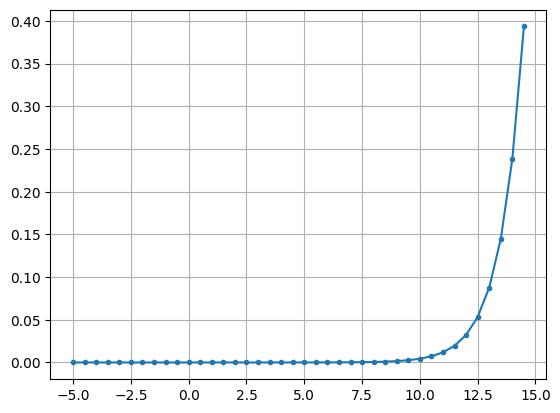

In [22]:
class Softmax(ActivationFunction):

    def activation_function(self) -> None:
        pass

    def execute_activation_function(self) -> None:
        e = tf.exp(self.results)
        self.results = e / tf.reduce_sum(e)


Softmax(tensor=tf.range(start=-5.0, limit=15.0,
        delta=0.5, dtype=tf.float32)).run()


# Softplus

$$
\operatorname{ln}(1 + e^x)
$$


Results: 
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1920928e-07
 3.5762781e-07 8.3446469e-07 2.2649740e-06 6.1988640e-06 1.6689160e-05
 4.5417706e-05 1.2337400e-04 3.3539868e-04 9.1141637e-04 2.4756519e-03
 6.7153489e-03 1.8149961e-02 4.8587330e-02 1.2692805e-01 3.1326166e-01
 6.9314718e-01 1.3132616e+00 2.1269281e+00 3.0485873e+00 4.0181499e+00
 5.0067153e+00 6.0024757e+00 7.0009117e+00 8.0003357e+00 9.0001230e+00
 1.0000046e+01 1.1000016e+01 1.2000006e+01 1.3000002e+01 1.4000001e+01
 1.5000000e+01 1.6000000e+01 1.7000000e+01 1.8000000e+01 1.9000000e+01]


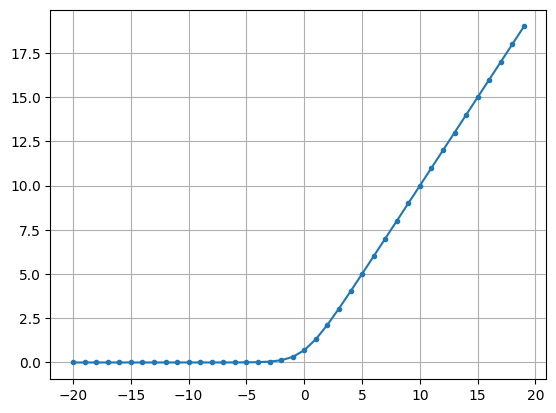

In [23]:
class Softplus(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        return tf.math.log(1 + tf.exp(x))


Softplus(tensor=tf.range(start=-20.0, limit=20.0, dtype=tf.float32)).run()


# Softsign


Results: 
[-0.95238096 -0.95       -0.94736844 -0.9444444  -0.9411765  -0.9375
 -0.93333334 -0.9285714  -0.9230769  -0.9166667  -0.90909094 -0.9
 -0.8888889  -0.875      -0.85714287 -0.8333333  -0.8        -0.75
 -0.6666667  -0.5         0.          0.5         0.6666667   0.75
  0.8         0.8333333   0.85714287  0.875       0.8888889   0.9
  0.90909094  0.9166667   0.9230769   0.9285714   0.93333334  0.9375
  0.9411765   0.9444444   0.94736844  0.95      ]


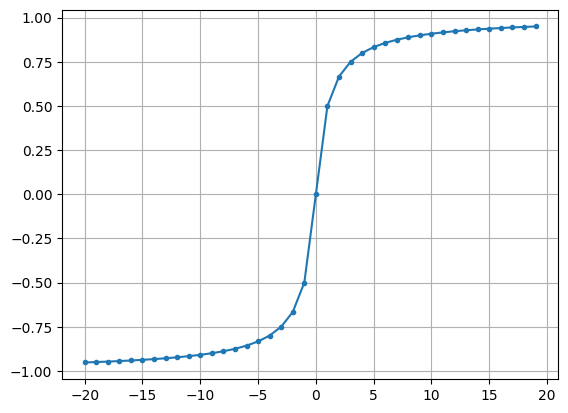

In [24]:
class Softsign(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        return x / (tf.abs(x) + 1)


Softsign(tensor=tf.range(start=-20.0, limit=20.0, dtype=tf.float32)).run()


# Swish

Swish activation function which returns x\*sigmoid(x). It is a smooth,
non-monotonic function that consistently matches or outperforms ReLU on deep
networks, it is unbounded above and bounded below.

$$
\frac{x}{1 + e^{-x}}
$$


Results: 
[-0.00637736 -0.01483574 -0.03346425 -0.07194484 -0.14227763 -0.23840584
 -0.26894143  0.          0.7310586   1.761594    2.8577223   3.928055
  4.966536    5.9851646 ]


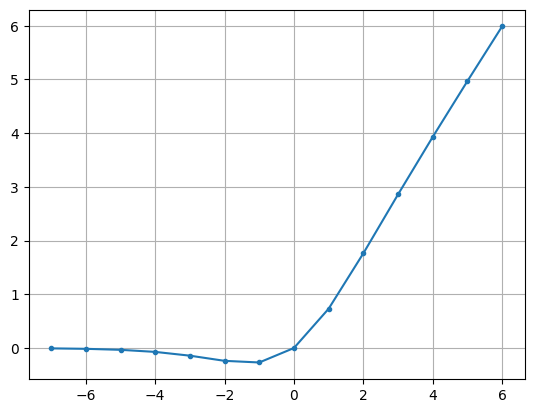

In [25]:
class Swish(ActivationFunction):

    def sigmoid(self, x: tf.Variable) -> tf.Variable:
        return 1 / (1 + tf.exp(tf.math.negative(x)))

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        return tf.multiply(self.sigmoid(x), x)


Swish(tensor=tf.range(start=-7.0, limit=7.0, dtype=tf.float32)).run()


# Tanh (or Hyperbolic tangent)

$$
\frac{e^x - e^{-x}}{e^x + e^{-x}}
$$


Results: 
[-1.         -1.         -1.         -1.         -0.9999998  -0.99999934
 -0.99999845 -0.9999954  -0.9999877  -0.99996656 -0.9999091  -0.99975324
 -0.9993293  -0.9981779  -0.9950547  -0.98661435 -0.9640275  -0.9051482
 -0.7615942  -0.46211714  0.          0.46211714  0.7615942   0.9051482
  0.9640275   0.98661435  0.9950547   0.9981779   0.9993293   0.99975324
  0.9999091   0.99996656  0.9999877   0.9999954   0.99999845  0.99999934
  0.9999998   1.          1.          1.        ]


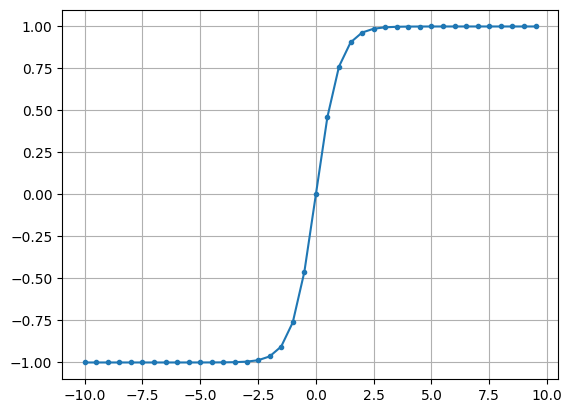

In [26]:
class Tanh(ActivationFunction):

    def activation_function(self, x: tf.Variable) -> tf.Variable:
        a = tf.exp(x)
        b = tf.exp(tf.math.negative(x))

        return (a - b) / (a + b)


Tanh(tensor=tf.range(start=-10.0, limit=10.0, delta=0.5, dtype=tf.float32)).run()
